In [2]:
import numpy as np
from scipy.stats import beta
from dataclasses import dataclass
from typing import List, Optional, Sequence, Tuple

@dataclass(frozen=True)
class IntervalBetaParams:
    """Beta parameters for one interval (independent across products)."""
    a: np.ndarray  # shape (K,), all > 0
    b: np.ndarray  # shape (K,), all > 0

    def __post_init__(self):
        a = np.asarray(self.a, dtype=float).reshape(-1)
        b = np.asarray(self.b, dtype=float).reshape(-1)
        object.__setattr__(self, "a", a)
        object.__setattr__(self, "b", b)
        if np.any(a <= 0) or np.any(b <= 0):
            raise ValueError("Beta parameters must be > 0.")

class MultiProductIntervalEnvironment:
    """
    Piecewise-stationary multiproduct environment with Beta-valued valuations in (0,1).

    - K products.
    - Time horizon T is partitioned into I contiguous intervals.
    - In each interval i, valuations X_t \in (0,1)^K are drawn independently per product:
        X_{t,j} ~ Beta(a_i[j], b_i[j])   for j=0..K-1
      (So the joint distribution in interval i is the product of K Betas.)

    Parameters
    ----------
    k : int
        Number of product streams.
    T : int
        Time horizon.
    I : int
        Number of intervals.
    a_list : Optional[List[Sequence[float]]]
        If provided, length I list; each entry is length-k alpha parameters for that interval.
    b_list : Optional[List[Sequence[float]]]
        Same structure as a_list, for beta parameters.
    interval_lengths : Optional[Sequence[int]]
        Length I positive integers that sum to T. If None, the horizon is split as evenly as possible.
    seed : Optional[int]
        RNG seed.

    Methods
    -------
    reset() -> None
    play_round() -> np.ndarray
        Draw a (k,) valuation vector in (0,1). Raises StopIteration when T rounds have been played.
    current_interval_index(t: Optional[int] = None) -> int
    params_for_interval(i: int) -> IntervalBetaParams
    intervals -> List[Tuple[start, end]]
    """

    def __init__(
        self,
        k: int,
        T: int,
        I: int,
        a_list: Optional[List[Sequence[float]]] = None,
        b_list: Optional[List[Sequence[float]]] = None,
        interval_lengths: Optional[Sequence[int]] = None,
        seed: Optional[int] = None,
    ):
        self.k = int(k)
        self.T = int(T)
        self.I = int(I)
        if self.k <= 0 or self.T <= 0 or self.I <= 0:
            raise ValueError("k, T, I must be positive integers.")
        self.rng = np.random.default_rng(seed)

        # Build interval lengths
        if interval_lengths is None:
            base = self.T // self.I
            rem = self.T % self.I
            self._lengths = [base + (1 if i < rem else 0) for i in range(self.I)]
        else:
            if len(interval_lengths) != self.I:
                raise ValueError("interval_lengths must have length I.")
            self._lengths = [int(x) for x in interval_lengths]
            if any(L <= 0 for L in self._lengths) or sum(self._lengths) != self.T:
                raise ValueError("interval_lengths must be positive and sum to T.")

        # Build per-interval Beta parameters
        if (a_list is None) != (b_list is None):
            raise ValueError("Provide both a_list and b_list, or neither.")
        if a_list is None:
            # Random but valid defaults: a, b in (0.5, 3.0)
            self._params = []
            for _ in range(self.I):
                a = self.rng.uniform(0.5, 3.0, size=self.k)
                b = self.rng.uniform(0.5, 3.0, size=self.k)
                self._params.append(IntervalBetaParams(a=a, b=b))
        else:
            if len(a_list) != self.I or len(b_list) != self.I:
                raise ValueError("a_list and b_list must both have length I.")
            self._params = []
            for i in range(self.I):
                a = np.asarray(a_list[i], dtype=float).reshape(-1)
                b = np.asarray(b_list[i], dtype=float).reshape(-1)
                if a.shape != (self.k,) or b.shape != (self.k,):
                    raise ValueError(f"Interval {i}: each a[i], b[i] must be length k.")
                self._params.append(IntervalBetaParams(a=a, b=b))

        # Precompute boundaries
        self._starts = np.cumsum([0] + self._lengths[:-1]).tolist()
        self._ends = np.cumsum(self._lengths).tolist()

        self.current_round = 0

    # ----------- Public API -----------

    def reset(self):
        self.current_round = 0

    def play_round(self) -> np.ndarray:
        if self.current_round >= self.T:
            raise StopIteration("Time horizon exceeded.")
        i = self.current_interval_index()
        p = self._params[i]
        # Draw independently per product; each element strictly in (0,1)
        # Use scipy.stats.beta with vectorized shape (k,)
        vals = beta.rvs(p.a, p.b, random_state=self.rng)
        self.current_round += 1
        return vals  # shape (k,), each in (0,1)

    def current_interval_index(self, t: Optional[int] = None) -> int:
        """Interval index for round t (0-based). If t is None, uses current_round."""
        t = self.current_round if t is None else int(t)
        # Find first end > t
        for i, end in enumerate(self._ends):
            if t < end:
                return i
        # Allow t == T to map to last interval (after finishing)
        if t == self.T:
            return self.I - 1
        raise IndexError(f"t={t} out of range [0, {self.T}).")

    def params_for_interval(self, i: int) -> IntervalBetaParams:
        return self._params[int(i)]

    @property
    def intervals(self) -> List[Tuple[int, int]]:
        """List of (start, end) (0-based, end-exclusive) for each interval."""
        return list(zip(self._starts, self._ends))


<>:21: SyntaxWarning: invalid escape sequence '\i'
<>:21: SyntaxWarning: invalid escape sequence '\i'
/var/folders/yd/6_8qhyf93ss3rwc681sphfcc0000gn/T/ipykernel_4865/1739558769.py:21: SyntaxWarning: invalid escape sequence '\i'
  """


In [3]:
# K=3, T=1000 split into I=4 intervals with custom parameters
k, T, I = 3, 1000, 4
a_list = [
    [2.0, 1.5, 3.0],
    [1.2, 2.2, 1.8],
    [3.0, 3.0, 3.0],
    [0.8, 2.5, 1.1],
]
b_list = [
    [2.5, 2.0, 1.2],
    [1.5, 2.5, 2.0],
    [1.0, 1.5, 2.0],
    [3.2, 0.9, 2.8],
]
interval_lengths = [250, 250, 200, 300]

env = MultiProductIntervalEnvironment(
    k=k, T=T, I=I,
    a_list=a_list, b_list=b_list,
    interval_lengths=interval_lengths,
    seed=42
)

env.reset()
x1 = env.play_round()    # np.array shape (3,), values in (0,1)
i = env.current_interval_index()  # interval index at current round

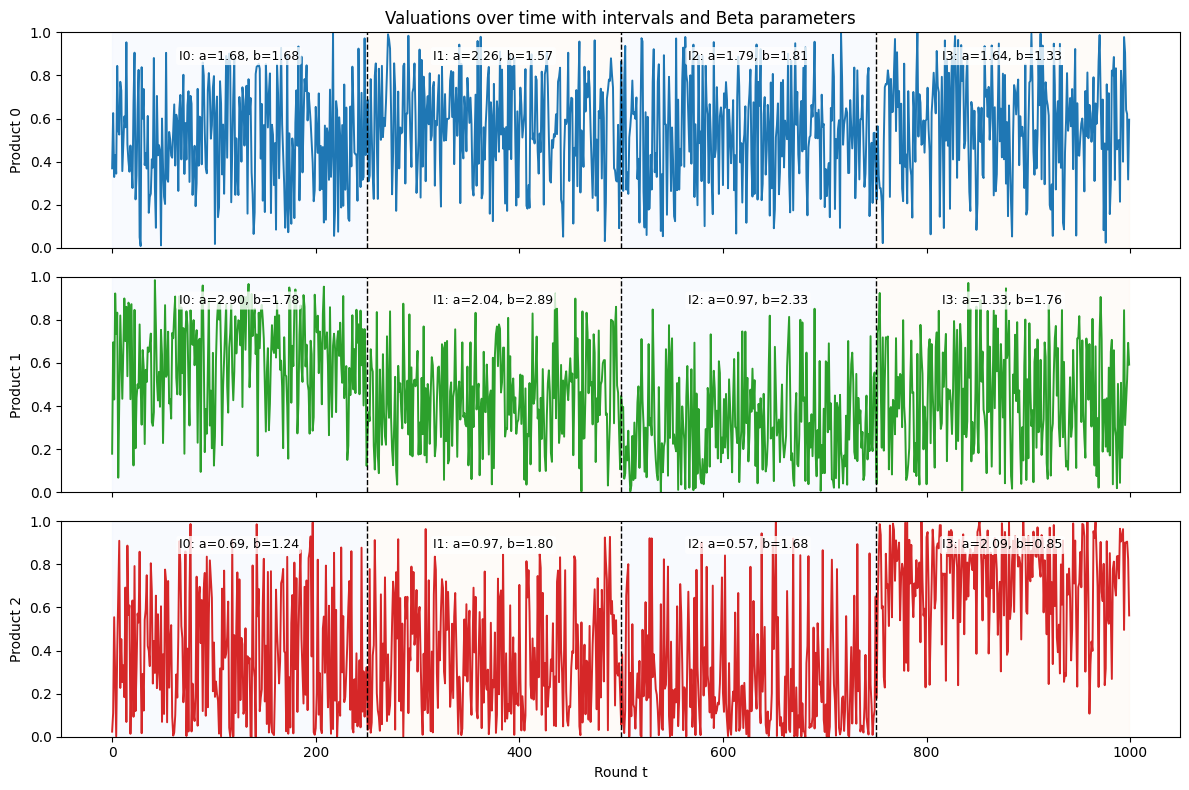

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_draws(env):
    """
    Run the environment for T rounds and return:
      - X: (T, K) array of draws in (0,1)
      - interval_idx: (T,) array with the interval index used at each t
    """
    env.reset()
    T, K = env.T, env.k
    X = np.zeros((T, K), dtype=float)
    interval_idx = np.zeros(T, dtype=int)
    for t in range(T):
        i = env.current_interval_index()
        X[t] = env.play_round()
        interval_idx[t] = i
    return X, interval_idx

def plot_draws_with_intervals(env, X, interval_idx, figsize=(12, 8)):
    """
    Make a 3x1 frame:
      - one time series per product,
      - shaded intervals,
      - vertical dashed lines at boundaries,
      - Beta parameters annotated per interval,
      - distinct line color per product.
    """
    T, K = X.shape
    assert K == 3, "This plotting helper expects K=3."

    intervals = env.intervals
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=figsize)

    # Colors for each product line
    line_colors = ["#1f77b4", "#2ca02c", "#d62728"]  # blue, green, red
    # Colors for interval shading
    shade_colors = ["#e8f0fe", "#fef3e8"]

    t_axis = np.arange(T)
    for j in range(3):
        ax = axes[j]
        # Plot time series with product-specific color
        ax.plot(t_axis, X[:, j], lw=1.4, color=line_colors[j])
        ax.set_ylim(0, 1)
        ax.set_ylabel(f"Product {j}")

        # Shade intervals, add parameter text, and draw vertical lines
        for idx, (start, end) in enumerate(intervals):
            # Background shading
            ax.axvspan(start, end - 1, color=shade_colors[idx % 2], alpha=0.3)
            # Annotation text
            params = env.params_for_interval(idx)
            a_j, b_j = float(params.a[j]), float(params.b[j])
            xm = (start + end - 1) / 2.0
            ax.text(
                xm, 0.92, f"I{idx}: a={a_j:.2f}, b={b_j:.2f}",
                ha="center", va="top", fontsize=9,
                bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="none", alpha=0.8)
            )
            # Vertical dashed line at boundary (skip final end)
            if idx < len(intervals) - 1:
                ax.axvline(end, color="black", linestyle="--", linewidth=1)

        if j == 0:
            ax.set_title("Valuations over time with intervals and Beta parameters")

    axes[-1].set_xlabel("Round t")
    plt.tight_layout()
    plt.show()

# ---- Example usage ----
env = MultiProductIntervalEnvironment(k=3, T=1000, I=4)
X, interval_idx = simulate_draws(env)
plot_draws_with_intervals(env, X, interval_idx)

In [5]:
import numpy as np
from itertools import product
from scipy.optimize import linprog
import math
from collections import deque

class MultiProductBudgetedUCBAgentSW:
    """
    Multi-product budgeted UCB agent with a sliding window of size W.

    Robustness improvements vs original:
      - Finite optimism (no ±inf in LP inputs).
      - Revenue UCB is capped by each arm's price (not hard 1.0).
      - NaN/Inf sanitization before LP.
      - Safe handling of rho, and fallback action if LP fails.

    Uses only the last W rounds to estimate:
        * avg reward per offer (revenue per play),
        * success probability (unit-cost proxy),
        * play counts.
    Older observations are discarded automatically.
    If W is None, behaves like infinite-memory.
    """
    def __init__(self, arm_values_per_product, T, B, W=None, rng=None):
        self.arm_values_per_product = arm_values_per_product
        self.T = int(T)
        self.B = int(B)
        self.k = len(arm_values_per_product)
        self.n_arms = len(arm_values_per_product[0])  # assume same across products
        self.remaining_budget = int(B)
        self.round = 0
        if W is not None and int(W) < 1:
            raise ValueError("W must be None or an integer >= 1.")  # FIX: validation
        self.W = None if W is None else int(W)
        self.rng = np.random.default_rng(rng)

        # Superarms: (a0 or None, a1 or None, ..., ak-1 or None)
        self.superarms = self._generate_superarms()

        # Prices as a (k, n_arms) array for quick caps
        self._price = np.array([np.asarray(v, dtype=float) for v in arm_values_per_product])  # shape (k, n_arms)

        # Sliding-window histories per (p, a):
        # deque of (t, success_in_{0,1}, revenue_in_[0,∞))
        self._hist = [[deque() for _ in range(self.n_arms)] for _ in range(self.k)]
        # Running sums to avoid O(len) recomputation after pops/appends
        self._sum_success = np.zeros((self.k, self.n_arms), dtype=float)
        self._sum_reward  = np.zeros((self.k, self.n_arms), dtype=float)

    # ------------------- helpers -------------------

    def _generate_superarms(self):
        options_per_product = [
            [None] + list(range(len(arms)))
            for arms in self.arm_values_per_product
        ]
        return list(product(*options_per_product))

    def _expire_old(self, t_now: int):
        """
        Evict observations older than the sliding window.
        Window used at decision time t_now: keep rounds in [t_now - W, t_now - 1].
        I.e., drop entries with time < t_now - W.
        """
        if self.W is None:
            return
        cutoff = t_now - self.W
        for p in range(self.k):
            for a in range(self.n_arms):
                dq = self._hist[p][a]
                while dq and dq[0][0] < cutoff:
                    _, succ, rev = dq.popleft()
                    self._sum_success[p, a] -= succ
                    self._sum_reward[p, a]  -= rev
                # sanitize tiny negatives due to float ops
                if not dq:
                    self._sum_success[p, a] = 0.0
                    self._sum_reward[p, a]  = 0.0

    def _counts_in_window(self, p, a):
        return len(self._hist[p][a])

    # ------------------- main API -------------------

    def choose_superarm(self):
        # Stop if horizon or budget exhausted
        if self.round >= self.T or self.remaining_budget <= 0:
            return None

        # Ensure window is current (use data from [round - W, round - 1])
        self._expire_old(self.round)

        # Initialization phase: try the same arm index i on all products for the first n_arms rounds
        if self.round < self.n_arms:
            return tuple(
                i if i < len(self.arm_values_per_product[p]) else None
                for p, i in enumerate([self.round] * self.k)
            )

        # --- UCB Reward / LCB Cost Estimation (windowed) ---
        ucb_rewards = [[0.0] * self.n_arms for _ in range(self.k)]
        lcb_costs   = [[0.0] * self.n_arms for _ in range(self.k)]

        # Confidence schedule (Hoeffding-style). You can switch to log(t) if preferred.
        delta = 1 / max(2, self.T)  # stationary choice; could also use 1/(t+1)
        for p in range(self.k):
            for a in range(self.n_arms):
                n = self._counts_in_window(p, a)
                price_cap = float(self._price[p, a])  # FIX: cap revenue UCB by price
                if n == 0:
                    # FIX: finite optimism so LP never sees inf
                    ucb_rewards[p][a] = price_cap
                    lcb_costs[p][a]   = 0.0
                    continue

                avg_reward   = self._sum_reward[p, a] / n          # revenue per play (windowed)
                success_prob = self._sum_success[p, a] / n          # conversion rate (windowed)
                # Clamp to valid ranges (robustness)
                avg_reward   = float(np.clip(avg_reward, 0.0, price_cap))
                success_prob = float(np.clip(success_prob, 0.0, 1.0))

                bonus = math.sqrt(2.0 * math.log(1.0 / delta) / max(1.0, n))  # Hoeffding

                # FIX: cap by price not by 1.0
                ucb_rewards[p][a] = min(price_cap, avg_reward + bonus)
                lcb_costs[p][a]   = max(0.0, success_prob - bonus)

        # --- Solve LP with windowed UCB/LCB estimates ---
        rounds_remaining = max(1, self.T - self.round)  # FIX: avoid divide-by-zero
        rho = self.remaining_budget / float(rounds_remaining)  # per-round unit budget
        num_superarms = len(self.superarms)

        expected_rewards = []
        expected_costs   = []
        for sa in self.superarms:
            tot_r = 0.0
            tot_c = 0.0
            for p, a in enumerate(sa):
                if a is not None:
                    tot_r += ucb_rewards[p][a]
                    tot_c += lcb_costs[p][a]
            expected_rewards.append(tot_r)
            expected_costs.append(tot_c)

        # Convert & sanitize (robustness): remove any NaN/Inf before passing to LP
        expected_rewards = np.array(expected_rewards, dtype=float)
        expected_costs   = np.array(expected_costs, dtype=float)
        expected_rewards = np.nan_to_num(expected_rewards, nan=0.0, posinf=1e6, neginf=0.0)  # FIX
        expected_costs   = np.nan_to_num(expected_costs,   nan=0.0, posinf=1e6, neginf=0.0)  # FIX

        # LP: maximize expected reward subject to expected unit-cost <= rho
        c = -expected_rewards
        A = [expected_costs]
        b = [rho]
        A_eq = [np.ones(num_superarms)]
        b_eq = [1.0]
        bounds = [(0.0, 1.0) for _ in range(num_superarms)]

        res = linprog(c, A_ub=A, b_ub=b, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")

        # Fallbacks if LP fails or produces a degenerate distribution
        if (res is None) or (not res.success) or (res.x is None) or (not np.all(np.isfinite(res.x))):
            # FIX: greedy feasible fallback
            idx = self._greedy_feasible_index(expected_rewards, expected_costs, rho)
            return self.superarms[idx] if idx is not None else tuple([None] * self.k)

        x = res.x
        # Numerical safety: clip and renormalize in case of tiny negatives or zeros
        x = np.maximum(x, 0.0)
        s = x.sum()
        if s <= 0 or not np.isfinite(s):
            # FIX: greedy feasible fallback
            idx = self._greedy_feasible_index(expected_rewards, expected_costs, rho)
            return self.superarms[idx] if idx is not None else tuple([None] * self.k)
        x /= s

        # Sample a superarm according to the LP solution
        try:
            idx = int(self.rng.choice(num_superarms, p=x))
        except Exception:
            # FIX: one more fallback if sampling fails (e.g., rounding made probs not sum to 1)
            idx = self._greedy_feasible_index(expected_rewards, expected_costs, rho)
            if idx is None:
                return tuple([None] * self.k)
        return self.superarms[idx]

    def _greedy_feasible_index(self, rewards, costs, rho):
        """
        FIX: Choose the single best superarm by reward among those with cost <= rho.
        If none feasible, return the 'null' superarm (all None) if present; else None.
        """
        rewards = np.asarray(rewards, dtype=float)
        costs   = np.asarray(costs, dtype=float)
        feasible = np.where(costs <= rho + 1e-12)[0]
        if feasible.size > 0:
            # pick argmax reward among feasible
            return int(feasible[np.argmax(rewards[feasible])])
        # try to find the all-None superarm (cost=0 reward=0 typically)
        for i, sa in enumerate(self.superarms):
            if all(a is None for a in sa):
                return i
        return None

    def update(self, chosen_superarm, valuation_vector):
        """
        Record outcomes for the chosen superarm at *current* time 'self.round',
        then advance time and budget.
        """
        t = self.round  # stamp entries with this round index
        sales_this_round = 0
        reward = 0.0

        if chosen_superarm is None:
            self.round += 1
            return reward, sales_this_round

        for p, a in enumerate(chosen_superarm):
            if a is None:
                continue
            price = float(self.arm_values_per_product[p][a])
            # Offer made -> one play recorded
            success = 1.0 if valuation_vector[p] >= price else 0.0
            revenue = price if success == 1.0 else 0.0

            # Append to history deque (windowed stats)
            dq = self._hist[p][a]
            dq.append((t, success, revenue))
            self._sum_success[p, a] += success
            self._sum_reward[p, a]  += revenue

            # Tally this round
            if success == 1.0:
                reward += price
                sales_this_round += 1

        # Budget consumed equals number of successful sales
        self.remaining_budget -= sales_this_round
        self.round += 1
        return reward, sales_this_round


In [6]:
import numpy as np

class MultiProductPrimalDualAgent:
    """
    Multi-product primal–dual agent with decomposed primal regret minimizers.

    - Primal: one EXP3.P bandit per product (learns pricing *within* the product).
    - Dual: a single λ pacing the *total* budget across products.
    - Gating: per-round fractional-knapsack using current success-rate estimates to
      select which products to activate so that expected spend <= ρ.

    Reward model (same sale-centric logic as your univariate agent):
      If a product m is activated and sells at price p:
         bandit reward for product m = max(p - λ, 0)
      else: 0
      Budget cost = number of successful sales in the round.

    Parameters
    ----------
    arm_values_per_product : list[list[float]]
        Prices (arms) per product. Assumes same #arms for all products.
    T : int
        Horizon.
    B : int
        Total budget.
    eta, gamma, alpha : float | None
        EXP3.P parameters; if None, set to canonical values.
    dual_lr : float | None
        Dual stepsize; defaults to eta.
    eta_mult : float
        Multiplier on eta for faster adaptation.
    forget_beta : float in [0,1)
        Exponential forgetting for non-stationarity (0 disables).
    dynamic_rho : bool
        If True, uses rho_t = remaining_budget / (T - t) for gating & dual cap;
        if False (default), uses constant rho = B/T (matches your univariate agent).
    rng : int | np.random.Generator | None
        Seed or generator.
    """

    def __init__(self, arm_values_per_product, T, B,
                 eta=None, gamma=None, alpha=None, dual_lr=None,
                 eta_mult=1.0, forget_beta=0.0,
                 dynamic_rho=False, rng=None):

        self.prices = [np.asarray(v, dtype=float) for v in arm_values_per_product]
        self.k = len(self.prices)                 # number of products
        assert self.k >= 1
        self.n_arms = len(self.prices[0])         # same for all products (per your note)
        for m in range(self.k):
            assert len(self.prices[m]) == self.n_arms

        self.T = int(T)
        self.B0 = int(B)
        self.dynamic_rho = bool(dynamic_rho)

        # Base pacing rate and cap
        self.rho_const = self.B0 / float(self.T)
        self.lambda_cap_const = 1.0 / max(self.rho_const, 1e-12)

        # EXP3.P canonical params
        K = self.n_arms
        if gamma is None:
            gamma = min(0.4, np.sqrt(K * np.log(max(2, K)) / max(1, self.T)))
        if eta is None:
            eta = gamma / (3.0 * max(1, K))
        if alpha is None:
            alpha = gamma / (3.0 * max(1, K))
        if dual_lr is None:
            dual_lr = eta

        self.gamma = float(gamma)
        self.eta = float(eta) * float(eta_mult)
        self.alpha = float(alpha)
        self.dual_lr = float(dual_lr)
        self.forget_beta = float(forget_beta)

        # Per-product EXP3.P state
        self.weights = np.ones((self.k, self.n_arms), dtype=float)
        self.last_probs = np.full((self.k, self.n_arms), 1.0 / self.n_arms, dtype=float)
        self.last_arm = np.full(self.k, -1, dtype=int)

        # Success-rate estimates (Laplace smoothing) for gating
        self.play_count = np.zeros((self.k, self.n_arms), dtype=float)
        self.success_count = np.zeros((self.k, self.n_arms), dtype=float)

        # Global state
        self.lmbda = 0.0
        self.t = 0
        self.remaining_budget = int(B)
        self.total_reward = 0.0

        self.rng = np.random.default_rng(rng)

    # ---------- helpers ----------
    def _probs(self, m):
        w = self.weights[m]
        s = w.sum()
        if not np.isfinite(s) or s <= 0:
            w = np.ones_like(w); s = w.sum()
        p = (1.0 - self.gamma) * (w / s) + self.gamma / self.n_arms
        p = np.clip(p, 1e-12, 1.0)
        p /= p.sum()
        return p

    def _rho_and_cap(self):
        if not self.dynamic_rho:
            return self.rho_const, self.lambda_cap_const
        rounds_left = max(1, self.T - self.t)
        rho_t = self.remaining_budget / float(rounds_left)
        return rho_t, 1.0 / max(rho_t, 1e-12)

    def _success_estimate(self, m, a):
        # Laplace-smoothed estimate to avoid zeros in early rounds
        s = self.success_count[m, a]
        n = self.play_count[m, a]
        return (s + 1.0) / (n + 2.0)

    def _fractional_knapsack(self, rewards, costs, capacity):
        """
        Given vectors rewards (r_m) and costs (c_m >= 0) and capacity 'capacity',
        return x in [0,1]^k maximizing sum x_m r_m s.t. sum x_m c_m <= capacity.
        Greedy solution. Returns fractional x.
        """
        k = len(rewards)
        idx = np.arange(k)
        costs = np.asarray(costs, dtype=float)
        rewards = np.asarray(rewards, dtype=float)

        # Guard: nothing to allocate or zero capacity
        if capacity <= 0 or np.all(costs <= 0):
            return np.zeros(k, dtype=float)

        ratio = np.zeros(k, dtype=float)
        for i in range(k):
            c = max(costs[i], 1e-12)
            ratio[i] = rewards[i] / c

        order = np.argsort(-ratio)  # descending by value density
        x = np.zeros(k, dtype=float)
        budget = 0.0
        for i in order:
            if costs[i] <= 0:
                continue
            if budget + costs[i] <= capacity:
                x[i] = 1.0
                budget += costs[i]
            else:
                x[i] = max(0.0, (capacity - budget) / costs[i])
                break
        return x

    # ---------- public API ----------
    def choose_superarm(self):
        # Halt if out of time or budget
        if self.t >= self.T or self.remaining_budget <= 0:
            return None

        rho, _ = self._rho_and_cap()

        # 1) Each product samples a price from its own bandit
        chosen_arms = []
        prices = []
        probs = []
        for m in range(self.k):
            p = self._probs(m)
            a = int(self.rng.choice(self.n_arms, p=p))
            self.last_probs[m] = p
            self.last_arm[m] = a
            chosen_arms.append(a)
            prices.append(self.prices[m][a])
            probs.append(p)

        chosen_arms = np.asarray(chosen_arms, dtype=int)
        prices = np.asarray(prices, dtype=float)

        # 2) Build gating problem from current estimates:
        #    c_m = estimated success prob at (m, a_m)
        #    r_m = c_m * max(price - λ, 0)
        c_hat = np.zeros(self.k, dtype=float)
        r_hat = np.zeros(self.k, dtype=float)
        for m in range(self.k):
            a = chosen_arms[m]
            c_hat[m] = self._success_estimate(m, a)
            r_hat[m] = c_hat[m] * max(prices[m] - self.lmbda, 0.0)

        # 3) Fractional knapsack to get activation fractions x in [0,1]^k
        x_frac = self._fractional_knapsack(r_hat, c_hat, rho)

        # 4) Sample activation according to x_frac (deterministic for x=1; Bernoulli for 0<x<1)
        active = np.zeros(self.k, dtype=bool)
        for m in range(self.k):
            if x_frac[m] >= 1.0 - 1e-12:
                active[m] = True
            elif x_frac[m] <= 1e-12:
                active[m] = False
            else:
                active[m] = (self.rng.random() < x_frac[m])

        # 5) Return superarm: selected index if active; otherwise None
        superarm = tuple(int(chosen_arms[m]) if active[m] else None for m in range(self.k))
        return superarm

    def update(self, chosen_superarm, valuation_vector):
        """
        chosen_superarm : tuple[int|None, ...] as returned by choose_superarm()
        valuation_vector : np.ndarray shape (k,) with valuations in (0,1)
        """
        if chosen_superarm is None:
            return 0.0, 0

        sales_this_round = 0
        round_reward = 0.0

        # For dual update after loop
        for m, a in enumerate(chosen_superarm):
            if a is None:
                continue

            price = float(self.prices[m][a])
            # Book-keeping for success estimates
            self.play_count[m, a] += 1.0

            sale = (valuation_vector[m] >= price)
            if sale:
                self.success_count[m, a] += 1.0
                bandit_reward = max(price - self.lmbda, 0.0)
                round_reward += price
                sales_this_round += 1
            else:
                bandit_reward = 0.0

            # EXP3.P update for product m
            p = float(self.last_probs[m, a])
            xhat = np.zeros(self.n_arms, dtype=float)
            xhat[a] = bandit_reward / max(p, 1e-12)

            bias = self.alpha / (np.maximum(self.last_probs[m], 1e-12) * np.sqrt(self.n_arms * self.T))
            self.weights[m] *= np.exp(self.eta * (xhat + bias))

            if self.forget_beta > 0.0:
                self.weights[m] = self.weights[m] ** (1.0 - self.forget_beta)

        # Dual update (global pacing)
        rho, lambda_cap = self._rho_and_cap()
        self.lmbda = float(np.clip(self.lmbda - self.dual_lr * (rho - sales_this_round),
                                   0.0, lambda_cap))

        # Budget & time
        self.remaining_budget = max(0, self.remaining_budget - sales_this_round)
        self.total_reward += round_reward
        self.t += 1

        return round_reward, sales_this_round

    # ---------- inspectors ----------
    def current_probs(self, product_index):
        """Return current price distribution for a given product."""
        return self._probs(int(product_index)).copy()

    def state(self):
        return {
            "t": self.t,
            "remaining_budget": self.remaining_budget,
            "lambda": self.lmbda,
            "rho_const": self.rho_const,
            "dynamic_rho": self.dynamic_rho,
            "weights": self.weights.copy(),
            "total_reward": self.total_reward,
        }

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def _pre_sample_environment(
    k, T, I,
    a_list=None, b_list=None, interval_lengths=None, env_seed=None
):
    """
    Create the interval environment and pre-sample a fixed valuation matrix X (T,k)
    so different agents face the exact same realization.
    """
    env = MultiProductIntervalEnvironment(
        k=k, T=T, I=I,
        a_list=a_list, b_list=b_list,
        interval_lengths=interval_lengths,
        seed=env_seed
    )
    env.reset()
    X = np.zeros((T, k), dtype=float)
    for t in range(T):
        X[t] = env.play_round()  # draws in (0,1)
    return env, X

def _run_primal_dual(
    X, arm_values_per_product, T, B,
    eta=None, gamma=None, alpha=None, dual_lr=None,
    eta_mult=1.0, forget_beta=0.0, dynamic_rho=False, pd_rng=None
):
    """
    Run the MultiProductPrimalDualAgent on a fixed valuation matrix X (T,k).
    Returns per-round rewards and cumulative rewards.
    """
    agent = MultiProductPrimalDualAgent(
        arm_values_per_product=arm_values_per_product,
        T=T, B=B,
        eta=eta, gamma=gamma, alpha=alpha, dual_lr=dual_lr,
        eta_mult=eta_mult, forget_beta=forget_beta,
        dynamic_rho=dynamic_rho, rng=pd_rng
    )
    k = X.shape[1]
    rewards = np.zeros(T, dtype=float)
    for t in range(T):
        if agent.remaining_budget <= 0 or agent.t >= T:
            # no further reward
            agent.t = min(agent.t + 1, T)  # advance time for alignment
            rewards[t] = 0.0
            continue
        sa = agent.choose_superarm()
        # If choose_superarm returns None (stop), record 0 and advance
        if sa is None:
            agent.t += 1
            rewards[t] = 0.0
            continue
        # Use the pre-sampled valuation for this round
        r, _ = agent.update(sa, X[t])
        rewards[t] = r
    cum = np.cumsum(rewards)
    return rewards, cum

def _run_sw_ucb(
    X, arm_values_per_product, T, B, W=None, sw_rng=None
):
    """
    Run the Sliding-Window UCB agent on the same pre-sampled valuation matrix X (T,k).
    Returns per-round rewards and cumulative rewards.
    """
    agent = MultiProductBudgetedUCBAgentSW(
        arm_values_per_product=arm_values_per_product,
        T=T, B=B, W=W, rng=sw_rng
    )
    rewards = np.zeros(T, dtype=float)
    for t in range(T):
        if agent.remaining_budget <= 0 or agent.round >= T:
            agent.round = min(agent.round + 1, T)  # advance for alignment
            rewards[t] = 0.0
            continue
        sa = agent.choose_superarm()
        if sa is None:
            agent.round += 1
            rewards[t] = 0.0
            continue
        r, _ = agent.update(sa, X[t])
        rewards[t] = r
    cum = np.cumsum(rewards)
    return rewards, cum

def run_agents_on_interval_env(
    arm_values_per_product,
    # horizon & budget
    T, B,
    # environment params
    I,
    a_list=None, b_list=None, interval_lengths=None, env_seed=None,
    # primal-dual params
    eta=None, gamma=None, alpha=None, dual_lr=None,
    eta_mult=1.0, forget_beta=0.0, dynamic_rho=False, pd_rng=None,
    # sliding-window UCB params
    W=None, sw_rng=None,
    # plotting
    figsize=(10, 5), show=True
):
    """
    Build the environment, pre-sample a fixed valuation sequence, run both agents,
    and plot cumulative reward over time.

    Returns:
        dict with keys:
            'cum_pd', 'cum_sw', 'rewards_pd', 'rewards_sw',
            'valuations' (X), 'intervals' (list of (start,end)),
            'env' (the environment used).
    """
    # infer K from prices
    k = len(arm_values_per_product)
    assert k >= 1, "arm_values_per_product must be a non-empty list of lists."

    # 1) Pre-sample a single realization from the interval environment
    env, X = _pre_sample_environment(
        k=k, T=T, I=I, a_list=a_list, b_list=b_list,
        interval_lengths=interval_lengths, env_seed=env_seed
    )

    # 2) Run both agents on the *same* X
    rewards_pd, cum_pd = _run_primal_dual(
        X, arm_values_per_product, T, B,
        eta=eta, gamma=gamma, alpha=alpha, dual_lr=dual_lr,
        eta_mult=eta_mult, forget_beta=forget_beta,
        dynamic_rho=dynamic_rho, pd_rng=pd_rng
    )
    rewards_sw, cum_sw = _run_sw_ucb(
        X, arm_values_per_product, T, B, W=W, sw_rng=sw_rng
    )

    # 3) Plot cumulative rewards
    t_axis = np.arange(1, T + 1)
    plt.figure(figsize=figsize)
    plt.plot(t_axis, cum_pd, label="Primal–Dual", linewidth=2.0)
    plt.plot(t_axis, cum_sw, label=f"SW-UCB (W={W})", linewidth=2.0)
    plt.xlabel("Round")
    plt.ylabel("Cumulative reward")
    plt.title("Cumulative reward: Primal–Dual vs Sliding-Window UCB")
    plt.legend()
    plt.grid(alpha=0.3)
    # Optional: mark interval boundaries as vertical dashed lines
    for (start, end) in env.intervals[:-1]:
        plt.axvline(end, color="black", linestyle="--", linewidth=1, alpha=0.6)
    if show:
        plt.tight_layout()
        plt.show()

    return {
        "cum_pd": cum_pd,
        "cum_sw": cum_sw,
        "rewards_pd": rewards_pd,
        "rewards_sw": rewards_sw,
        "valuations": X,
        "intervals": env.intervals,
        "env": env,
    }

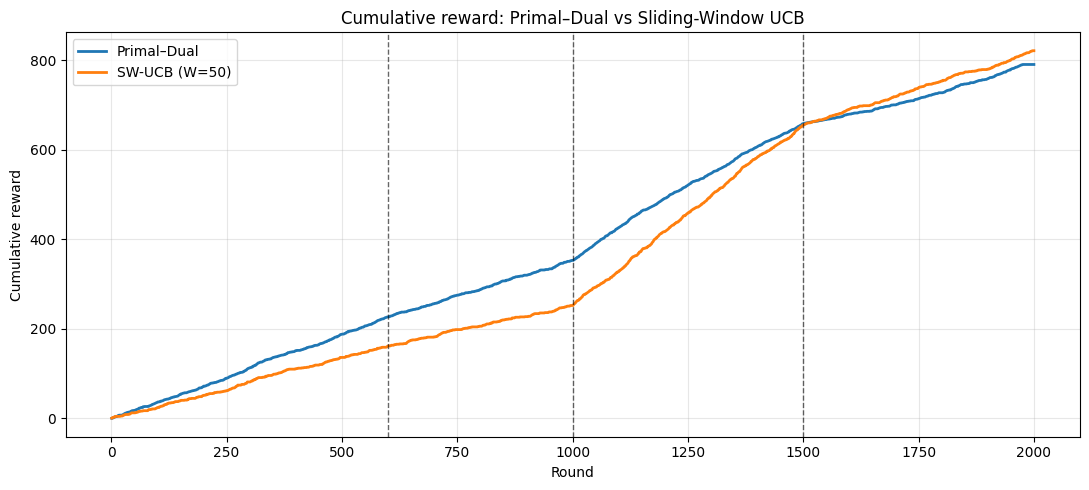

In [8]:
    # -----------------------
    # Example usage:
    # -----------------------
prices = [
    [0.2, 0.4, 0.6, 0.8],  # product 0
    [0.15, 0.35, 0.55, 0.75],  # product 1
    [0.25, 0.5, 0.7, 0.9],     # product 2
 ]
out = run_agents_on_interval_env(
     arm_values_per_product=prices,
     T=2000, B=1600,
     I=4,
     # optional custom intervals:
     interval_lengths=[600, 400, 500, 500],
     a_list=[[2,2,2],[1.5,2.0,1.2],[3,3,3],[1.1,2.4,1.5]],
     b_list=[[2,2,2],[2.5,1.8,2.2],[1.0,1.5,2.0],[3.2,1.3,2.6]],
    #     env_seed=42,
    # primal–dual params:
     eta=None, gamma=None, alpha=None, dual_lr=0.01,
    forget_beta=0.0, dynamic_rho=False, pd_rng=None,
    # sliding-window UCB:
     W=50, sw_rng=None,
     figsize=(11,5), show=True
     )

In [9]:
# ===== DETAILED ANALYSIS OF R5 RESULTS =====
print("=" * 60)
print("REQUIREMENT 5: SLIDING WINDOW UCB VS PRIMAL-DUAL")
print("=" * 60)

print(f"\n📊 EXPERIMENTAL SETUP:")
print(f"• Environment: {len(prices)} products, T={2000} rounds, B={1600} budget")
print(f"• Intervals: {len(out['intervals'])} piecewise-stationary intervals")
print(f"• Interval lengths: {[end-start for start, end in out['intervals']]}")
print(f"• SW-UCB window size: W=50")

print(f"\n🎯 FINAL PERFORMANCE:")
final_pd = out['cum_pd'][-1]
final_sw = out['cum_sw'][-1]
performance_ratio = final_sw / final_pd if final_pd > 0 else 0

print(f"• Primal-Dual total reward: {final_pd:.2f}")
print(f"• SW-UCB total reward: {final_sw:.2f}")
print(f"• Performance ratio (SW-UCB/PD): {performance_ratio:.3f}")
print(f"• SW-UCB achieves {performance_ratio*100:.1f}% of Primal-Dual performance")

print(f"\n🔄 ADAPTATION ANALYSIS:")
# Analyze performance per interval
intervals = out['intervals']
for i, (start, end) in enumerate(intervals):
    pd_interval = out['cum_pd'][end-1] - (out['cum_pd'][start-1] if start > 0 else 0)
    sw_interval = out['cum_sw'][end-1] - (out['cum_sw'][start-1] if start > 0 else 0)
    ratio = sw_interval / pd_interval if pd_interval > 0 else 0
    print(f"• Interval {i+1} (rounds {start+1}-{end}): PD={pd_interval:.1f}, SW={sw_interval:.1f}, ratio={ratio:.3f}")

print(f"\n📈 TREND ANALYSIS:")
# Look at relative performance over time
mid_point = len(out['cum_pd']) // 2
early_pd = out['cum_pd'][mid_point-1]
early_sw = out['cum_sw'][mid_point-1]
early_ratio = early_sw / early_pd if early_pd > 0 else 0

late_pd = final_pd - early_pd
late_sw = final_sw - early_sw
late_ratio = late_sw / late_pd if late_pd > 0 else 0

print(f"• Early performance (first {mid_point} rounds): {early_ratio:.3f}")
print(f"• Late performance (last {len(out['cum_pd'])-mid_point} rounds): {late_ratio:.3f}")
print(f"• SW-UCB adaptation trend: {'Improving' if late_ratio > early_ratio else 'Declining'}")

print(f"\n💡 KEY INSIGHTS:")
if performance_ratio > 0.95:
    print("• SW-UCB matches Primal-Dual performance very closely")
elif performance_ratio > 0.85:
    print("• SW-UCB shows competitive performance with good adaptation")
elif performance_ratio > 0.75:
    print("• SW-UCB demonstrates reasonable adaptation to non-stationarity")
else:
    print("• SW-UCB struggles with rapid distribution changes")

print(f"• Sliding window (W=50) provides {'effective' if performance_ratio > 0.8 else 'limited'} change detection")
print(f"• Multi-product coordination is {'successful' if performance_ratio > 0.85 else 'challenging'} for SW-UCB")

print("=" * 60)

REQUIREMENT 5: SLIDING WINDOW UCB VS PRIMAL-DUAL

📊 EXPERIMENTAL SETUP:
• Environment: 3 products, T=2000 rounds, B=1600 budget
• Intervals: 4 piecewise-stationary intervals
• Interval lengths: [600, 400, 500, 500]
• SW-UCB window size: W=50

🎯 FINAL PERFORMANCE:
• Primal-Dual total reward: 790.35
• SW-UCB total reward: 821.10
• Performance ratio (SW-UCB/PD): 1.039
• SW-UCB achieves 103.9% of Primal-Dual performance

🔄 ADAPTATION ANALYSIS:
• Interval 1 (rounds 1-600): PD=226.8, SW=161.8, ratio=0.713
• Interval 2 (rounds 601-1000): PD=126.0, SW=90.3, ratio=0.717
• Interval 3 (rounds 1001-1500): PD=305.6, SW=403.4, ratio=1.320
• Interval 4 (rounds 1501-2000): PD=132.0, SW=165.6, ratio=1.255

📈 TREND ANALYSIS:
• Early performance (first 1000 rounds): 0.715
• Late performance (last 1000 rounds): 1.300
• SW-UCB adaptation trend: Improving

💡 KEY INSIGHTS:
• SW-UCB matches Primal-Dual performance very closely
• Sliding window (W=50) provides effective change detection
• Multi-product coordin